# 解决的问题

### 数据信息

数据基于ypjbyc/01_叶片结冰预测/train/15文件夹中的39.39万条数据。

### 数据处理

选择全部数据进行预处理，全部预处理过程约5分钟。

### 算法模型

LSTM

长短时记忆网络（LSTM）是一种神经网络方法，可用于建模长时间序列，分析长时间内的数据依赖关系。本实验中所采用的LSTM方法的网络结构如下：该网络共包含一个输入层、两个LSTM层、两个全连接层和一个输出层。其中LSTM层的LSTM神经元个数分别为60和40，两个全连接层的神经元个数分别为1040和520，输出层采用sigmoid输出预测概率。采用Adam优化器，损失函数为二进制交叉熵函数。共迭代50轮，每次迭代的batch size设为100.学习率的变化规则为：采用多项式迭代策略，每迭代100轮学习率进行一次衰减，初始学习率设为10-4，学习率阈值设为10-5，当学习率衰减到阈值，则不再变化。

本次LSTM的训练时间为：5620秒


### 参考
https://blog.csdn.net/zhaohaibo_/article/details/81876044


# Step 1 读取数据并分类

In [1]:
import os
os.chdir('/Users/janeyang/IAIExamples/2017-IndustryBigData/data/train/15')
import pandas as pd
import numpy as np


data = pd.read_csv("15_data.csv")
total = len(data)
print("sum of data:%d" % total)
des = data.describe()
fail_data = pd.read_csv("15_failureInfo.csv")
normal_data = pd.read_csv("15_normalInfo.csv")

sum of data:393886


## 分类标签：正常时间段和故障时间段

- label = 1: 故障时间区域
- label = 0: 正常时间区域
- label = -1:无效数据

In [2]:
# 转化data时间列为datetime格式
times = []
for i in range(len(data)):
    dt = pd.to_datetime(data.loc[i][0])
    times.append(dt)
    if(i%10000==0):
        print("complete %d / %d" % (i,len(data)))
times = pd.Series(times)
data.time = times

complete 0 / 393886
complete 10000 / 393886
complete 20000 / 393886
complete 30000 / 393886
complete 40000 / 393886
complete 50000 / 393886
complete 60000 / 393886
complete 70000 / 393886
complete 80000 / 393886
complete 90000 / 393886
complete 100000 / 393886
complete 110000 / 393886
complete 120000 / 393886
complete 130000 / 393886
complete 140000 / 393886
complete 150000 / 393886
complete 160000 / 393886
complete 170000 / 393886
complete 180000 / 393886
complete 190000 / 393886
complete 200000 / 393886
complete 210000 / 393886
complete 220000 / 393886
complete 230000 / 393886
complete 240000 / 393886
complete 250000 / 393886
complete 260000 / 393886
complete 270000 / 393886
complete 280000 / 393886
complete 290000 / 393886
complete 300000 / 393886
complete 310000 / 393886
complete 320000 / 393886
complete 330000 / 393886
complete 340000 / 393886
complete 350000 / 393886
complete 360000 / 393886
complete 370000 / 393886
complete 380000 / 393886
complete 390000 / 393886


In [3]:
# 转化normal_data & fail_data时间列为datetime 格式

def to_datetime(obj_pd): 
    Ser1 = obj_pd.iloc[:,0]
    Ser2 = obj_pd.iloc[:,1]
    for i in range(len(Ser1)):
        Ser1[i] = pd.to_datetime(Ser1[i])
        Ser2[i] = pd.to_datetime(Ser2[i])
    obj_pd.iloc[:,0] = Ser1
    obj_pd.iloc[:,1] = Ser2
    return obj_pd
        
normal_data = to_datetime(normal_data)
fail_data = to_datetime(fail_data)

In [4]:
# 根据datetime创建labels列表

labels = []
for i in range(len(times)):
    if(i%100000==0):
        print("complete %d / %d" % (i,len(times)))
    flag = 0
    for j in range(len(normal_data)):
        if((times[i] >= normal_data.startTime[j]) and (times[i] <= normal_data.endTime[j])):
            labels.append(0)
            flag = 1
            break
    for j in range(len(fail_data)):
        if(flag==1):
            break
        elif((times[i] >= fail_data.startTime[j]) and (times[i] <= fail_data.endTime[j])):
            labels.append(1)
            flag = 1
            break
    if(flag == 1):
        continue
    labels.append(-1)
print("complete all")

complete 0 / 393886
complete 100000 / 393886
complete 200000 / 393886
complete 300000 / 393886
complete all


In [5]:
# 打印三类数据信息

def data_category(labels,total):
    sum_inv = 0
    for i in range(len(labels)):
        if(labels[i] == -1):
            sum_inv = sum_inv + 1
    print("sum of invalid data : %d , %.2f %%" % (sum_inv,sum_inv/total*100))
    
    sum_nor = 0
    for i in range(len(labels)):
        if(labels[i] == 0):
            sum_nor = sum_nor + 1
    print("sum of normal data : %d , %.2f %% " % (sum_nor,sum_nor/total*100))
    
    sum_fail = 0
    for i in range(len(labels)):
        if(labels[i] == 1):
            sum_fail = sum_fail + 1
    print("sum of failure data : %d , %.2f %% " % (sum_fail,sum_fail/total*100))
    
data_category(labels,total)

sum of invalid data : 19785 , 5.02 %
sum of normal data : 350255 , 88.92 % 
sum of failure data : 23846 , 6.05 % 


In [6]:
# 删除无效数据
y = labels
indexes = []
for i in range(len(y)):
    if(y[i] == -1):
        indexes.append(i)
data = data.drop(indexes)
data = data.drop('time',axis=1)
for i in range(len(y)-1,-1,-1):
    if(y[i]==-1):
        y.pop(i)

# Step2 模型训练

In [7]:
# 选择训练集和测试集

from sklearn.model_selection import train_test_split
# 在选择的数据中，选择2/3作为训练集，1/3作为测试集
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.33, random_state=666, shuffle = False)# shuffle默认为True

# 随机选择百分之10的数据
# X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.9, random_state=666, shuffle = True)# shuffle默认为True
# 在选择的数据中，选择2/3作为训练集，1/3作为测试集
# X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.33, random_state=666, shuffle = False)# shuffle默认为True


In [8]:
# 归一化
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
X_train_scaled = min_max_scaler.fit_transform(X_train)
X_test_scaled = min_max_scaler.fit_transform(X_test)

Optimal number of features : 1
Ranking of features names: Index(['yaw_speed', 'pitch2_ng5_DC', 'yaw_position', 'pitch3_moto_tmp',
       'environment_tmp', 'power', 'acc_y', 'pitch3_angle',
       'wind_direction_mean', 'pitch2_angle', 'group', 'pitch1_ng5_DC',
       'pitch3_ng5_tmp', 'pitch1_speed', 'generator_speed', 'pitch1_moto_tmp',
       'int_tmp', 'pitch3_ng5_DC', 'wind_direction', 'pitch1_angle',
       'pitch2_moto_tmp', 'pitch3_speed', 'pitch2_speed', 'acc_x',
       'pitch2_ng5_tmp', 'pitch1_ng5_tmp', 'wind_speed'],
      dtype='object')
Ranking of features nums: [ 7 25  6 16 19  3 18 10  5  9 27 24 23 11  2 14 20 26  4  8 15 13 12 17
 22 21  1]


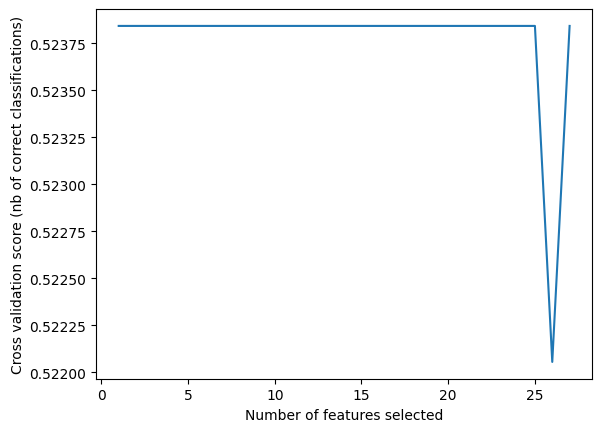

In [9]:
# 特征选择
# 使用RFECV进行特征选择，以交叉验证分数高低决定选取的特征数量
# 对特征进行排名
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
%matplotlib inline
svc = SVC(kernel="linear")
dt = DecisionTreeClassifier()
rfecv = RFECV(estimator=dt, step=1, cv=StratifiedKFold(2), scoring='accuracy')
rfecv.fit(X_train, y_train)
print("Optimal number of features : %d" % rfecv.n_features_)
print("Ranking of features names: %s" % X_train.columns[rfecv.ranking_-1])
print("Ranking of features nums: %s" % rfecv.ranking_)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
# Extract scores and determine number of steps
mean_scores = rfecv.cv_results_['mean_test_score']
n_features = len(mean_scores)

# Plot with corrected x/y values
plt.plot(range(1, n_features + 1), mean_scores[::-1])
plt.savefig("feature.jpg")
plt.show()

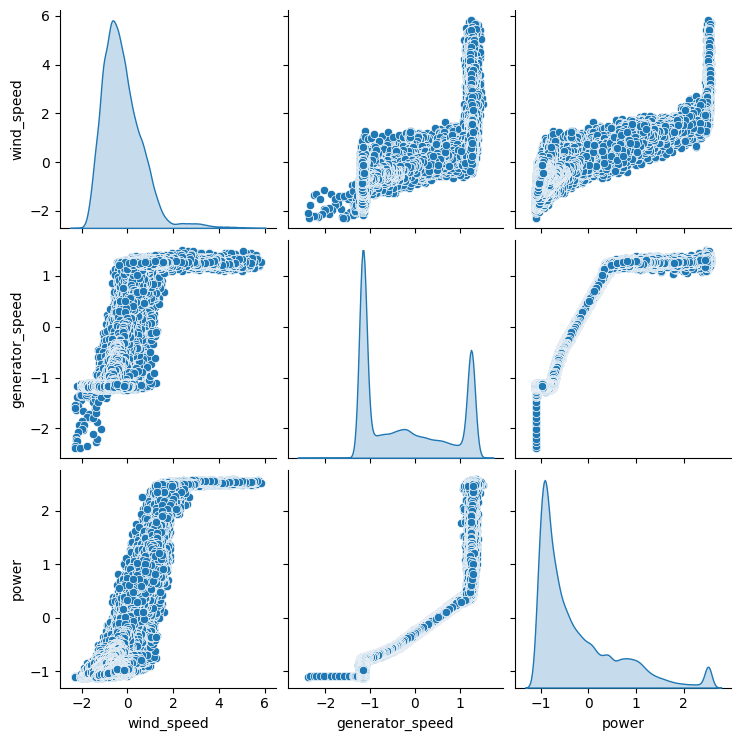

In [10]:
# 选取得分前三的特征，绘制特征对比图


import seaborn as sns
sns.pairplot(X_train, vars=["wind_speed","generator_speed", "power"],
             #palette="husl",
             diag_kind="kde")
plt.savefig("duibi.jpg")

In [11]:
# 绘制混淆矩阵
def plot_confusion_matrix(cm, classes, normalize=False,
                         title='Confusion matrix',
                         cmap=plt.cm.Blues):
    """
    Normalization can be applied by setting `normalize = True`.
    """
    plt.imshow(cm, interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")
    print(cm)
    
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j, i, cm[i,j],
                horizontalalignment="center",
                color="white" if cm[i,j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig("matrix.jpg")
    


In [12]:
from sklearn.metrics import matthews_corrcoef,accuracy_score,recall_score,precision_score,f1_score

def evaluate_model(y_true, y_pred, y_prob=None):
    """
    综合评估分类模型
    
    参数:
    y_true: 真实标签
    y_pred: 预测标签
    y_prob: 预测概率（可选，用于计算AUC-ROC）
    
    返回:
    metrics: 包含各种评估指标的字典
    """
    # 确保输入是 NumPy 数组
    if isinstance(y_true, list):
        y_true = np.array(y_true)
    if isinstance(y_pred, list):
        y_pred = np.array(y_pred)
    
    # 计算各种指标
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0),
        'mcc': matthews_corrcoef(y_true, y_pred)
    }
    
    # 如果有概率预测，计算 AUC-ROC
    if y_prob is not None:
        try:
            metrics['auc_roc'] = roc_auc_score(y_true, y_prob)
        except:
            metrics['auc_roc'] = None
    
    # 打印结果
    print("模型评估结果:")
    for key, value in metrics.items():
        if value is not None:
            print(f"{key}: {value:.4f}")
    
    return metrics

# 训练模型2: LSTM

In [14]:
import torch
import torch.nn as nn
import numpy as np
from torch.optim.lr_scheduler import CosineAnnealingLR

class LSTMModel(nn.Module):
    def __init__(self, input_shape):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size=input_shape[2], 
                            hidden_size=60, 
                            batch_first=True,
                            num_layers=1)  # 移除 return_sequences 参数
        self.lstm2 = nn.LSTM(input_size=60, 
                            hidden_size=40, 
                            batch_first=True,
                            num_layers=1)
        self.linear1 = nn.Linear(40, 1040)
        self.linear2 = nn.Linear(1040, 520)
        self.linear3 = nn.Linear(520, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # 第一个 LSTM 层返回所有时间步的输出
        x, (hn, cn) = self.lstm1(x)
        # 第二个 LSTM 层只返回最后一个时间步的输出
        x, (hn, cn) = self.lstm2(x)
        # 取最后一个时间步的输出
        x = hn[-1, :, :]
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.linear3(x)
        x = self.sigmoid(x)
        return x

def create_model(train_x):
    model = LSTMModel(train_x.shape)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    criterion = nn.BCELoss()
    return model, optimizer, criterion

In [15]:
import torch
import torch.nn as nn
import numpy as np
from torch.optim.lr_scheduler import CosineAnnealingLR

def Lstm_train(train_x, train_y):
    # 转换数据为 PyTorch 张量
    x_train_lstm = torch.FloatTensor(np.array(train_x)[:, :, np.newaxis])
    y_train = torch.FloatTensor(np.array(train_y))
    
    # 创建模型、优化器和损失函数
    model, optimizer, criterion = create_model(x_train_lstm)
    
    # 创建学习率调度器 (使用余弦退火)
    scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=0)
    
    # 训练模型
    history = {'loss': [], 'acc': []}
    model.train()
    
    for epoch in range(50):
        epoch_loss = 0
        epoch_acc = 0
        
        # 清零梯度
        optimizer.zero_grad()
        
        # 前向传播
        outputs = model(x_train_lstm)
        
        # 计算损失
        loss = criterion(outputs.squeeze(), y_train)
        
        # 反向传播和优化
        loss.backward()
        optimizer.step()
        
        # 更新学习率
        scheduler.step()
        
        # 计算准确率
        predicted = (outputs.squeeze() > 0.5).float()
        accuracy = (predicted == y_train).float().mean()
        
        # 记录历史
        history['loss'].append(loss.item())
        history['acc'].append(accuracy.item())
        
        # 打印训练进度
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/50], Loss: {loss.item():.4f}, Accuracy: {accuracy.item():.4f}')
    
    return model, history

In [16]:
import matplotlib.pyplot as plt

def lossfig(history):
    """
    绘制训练过程中的损失和准确率曲线
    
    参数:
    history: 包含训练历史记录的字典，应该有 'loss' 和 'acc' 键
    """
    epochs = range(len(history['acc']))
    
    plt.figure(figsize=(12, 5))
    
    # 绘制准确率曲线
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['acc'], 'b', label='Training accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # 绘制损失曲线
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['loss'], 'r', label='Training loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('loss_acc.jpg')
    plt.show()

Epoch [10/50], Loss: 0.3866, Accuracy: 0.9279
Epoch [20/50], Loss: 0.2788, Accuracy: 0.9279
Epoch [30/50], Loss: 0.2617, Accuracy: 0.9279
Epoch [40/50], Loss: 0.2599, Accuracy: 0.9279
Epoch [50/50], Loss: 0.2598, Accuracy: 0.9279
-----lstm的训练时间为：5620.404628038406
预测完成!
预测结果形状: (123454, 1)


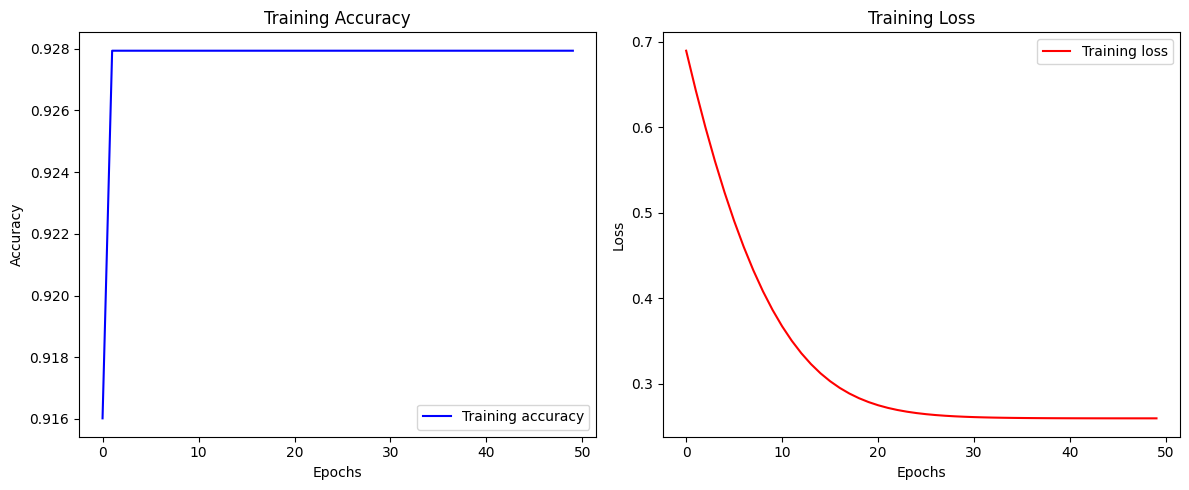

In [17]:
import time
start_time = time.time()
lstm_model, lstm_history = Lstm_train(X_train, y_train)
endingtime = time.time()
print("-----lstm的训练时间为：{}".format(endingtime-start_time))

# 准备测试数据
# 注意：X_test 应该与训练数据有相同的形状和预处理方式
X_test1 = np.expand_dims(X_test, axis=2)  # 将形状从 (n_samples, timestamps) 转换为 (n_samples, timestamps, 1)

# 将 numpy 数组转换为 PyTorch 张量
X_test_tensor = torch.FloatTensor(X_test1)

# 设置模型为评估模式
lstm_model.eval()

# 进行预测
with torch.no_grad():
    lstm_predict = lstm_model(X_test_tensor)
    
# 将预测结果转换为 numpy 数组
lstm_predict = lstm_predict.numpy()

# 如果输出是二分类问题，可以将概率转换为类别标签
# lstm_predict_binary = (lstm_predict > 0.5).astype(int)

print("预测完成!")
print(f"预测结果形状: {lstm_predict.shape}")
# lstm_predict = lstm_model.predict(X_test1)
lossfig(lstm_history)

Confusion matrix, without normalization
[[117670      0]
 [  5784      0]]


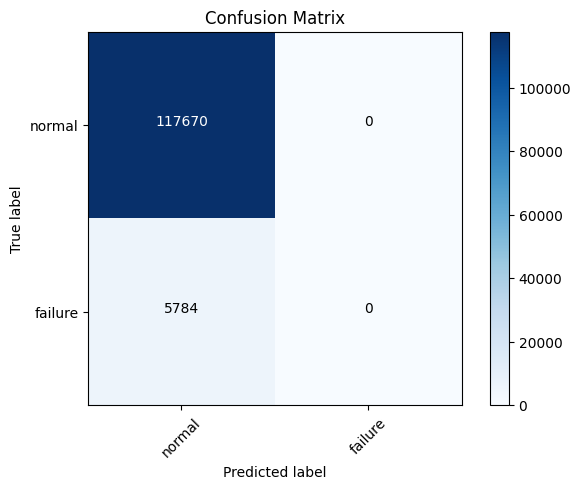

In [18]:
# 测试


# 如果 y_test 是列表，转换为 NumPy 数组
if isinstance(y_test, list):
    y_test = np.array(y_test)


# 确保 lstm_predict 是 NumPy 数组
if isinstance(lstm_predict, list):
    lstm_predict = np.array(lstm_predict)

# 调整形状 - 移除不必要的维度
lstm_predict = lstm_predict.squeeze()


# 将概率转换为类别
threshold = 0.5
y_pred_binary = (lstm_predict > threshold).astype(int)



from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_binary)
cm_plot_labels = ['normal', 'failure']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

# 评价指标

MCC是二进制分类中真实值和预测值之间的相关系数， 其取值范围为[-1,1]，数值越接近 1 代表模型预测越准。广泛应用于评价机器学习中的分类问题，尤其是正负样本不均衡情况下的分类问题 


In [19]:
# 评价模型
from sklearn.metrics import classification_report
print(classification_report(y_true=y_test, y_pred=y_pred_binary,zero_division=0))

# 使用评估函数
model_metrics = evaluate_model(y_test, y_pred_binary)

              precision    recall  f1-score   support

           0       0.95      1.00      0.98    117670
           1       0.00      0.00      0.00      5784

    accuracy                           0.95    123454
   macro avg       0.48      0.50      0.49    123454
weighted avg       0.91      0.95      0.93    123454

模型评估结果:
accuracy: 0.9531
precision: 0.0000
recall: 0.0000
f1: 0.0000
mcc: 0.0000
